In [ ]:
#include "queue.h"
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

int main() {
    printf("=== Демонстрация работы с очередью (анонимное отображение) ===\n");
    
    // Инициализация очереди
    printf("1. Инициализация очереди...\n");
    Queue *queue = queue_init(20);
    if (!queue) {
        printf("Ошибка инициализации очереди!\n");
        return 1;
    }
    
    printf("Состояние после инициализации: ");
    queue_print(queue);
    
    printf("2. Заполнение очереди 10 числами\n");
    queue_fill_random_asm(queue, 10);
    queue_print(queue);
    
    printf("3. Добавление элемента (777) в конец\n");
    queue_enqueue_asm(queue, 777);
    queue_print(queue);
    
    printf("4. Удаление элемента из начала\n");
    int dequeued = queue_dequeue_asm(queue);
    printf("Удаленный элемент: %d\n", dequeued);
    queue_print(queue);
    
    printf("5. Подсчет количества четных чисел\n");
    size_t even_count = queue_count_even_asm(queue);
    printf("Количество четных чисел: %zu\n", even_count);
    
    printf("6. Получение списка нечетных чисел\n");
    int odd_numbers[20];
    size_t odd_count = 0;
    queue_get_odd_numbers_asm(queue, odd_numbers, &odd_count);
    printf("Нечетные числа (%zu): ", odd_count);
    for (size_t i = 0; i < odd_count; i++) {
        printf("%d ", odd_numbers[i]);
    }
    printf("\n");
    
    printf("7. Подсчет количества простых чисел\n");
    size_t prime_count = queue_count_primes_asm(queue);
    printf("Количество простых чисел: %zu\n", prime_count);
    
    printf("8. Подсчет количества чисел, оканчивающихся на 1\n");
    size_t ends_with_1_count = queue_count_ends_with_1_asm(queue);
    printf("Количество чисел, оканчивающихся на 1: %zu\n", ends_with_1_count);
    
    printf("9. Удаление всех четных чисел\n");
    printf("До удаления: ");
    queue_print(queue);
    queue_remove_even_asm(queue);
    printf("После удаления: ");
    queue_print(queue);
    
    // Освобождение памяти
    queue_free(queue);
    
    printf("\nВсе функции очереди работают корректно!\n");
    printf("Программа завершена успешно!\n");
    return 0;
}

In [ ]:
format ELF64

section '.text' executable

public queue_enqueue_asm
public queue_dequeue_asm
public queue_fill_random_asm
public queue_count_even_asm
public queue_get_odd_numbers_asm
public queue_count_primes_asm
public queue_count_ends_with_1_asm
public queue_remove_even_asm

; void queue_enqueue_asm(Queue *q, int value)
queue_enqueue_asm:
    push rbp
    mov rbp, rsp
    
    ; rdi = q, esi = value
    mov r8, [rdi + 32]       ; q->capacity (смещение 32)
    mov r9, [rdi + 24]       ; q->size (смещение 24)
    
    cmp r9, r8
    jge .enqueue_full        ; если очередь полна
    
    ; Добавляем элемент в конец
    mov r10, [rdi]           ; q->data (смещение 0)
    mov r11, [rdi + 16]      ; q->rear (смещение 16)
    
    mov [r10 + r11 * 4], esi ; q->data[rear] = value
    
    ; Обновляем rear и size
    inc r11
    cmp r11, r8
    jl .no_wrap_rear
    xor r11, r11             ; обнуляем если достигли capacity
.no_wrap_rear:
    mov [rdi + 16], r11      ; q->rear = new_rear
    
    mov r9, [rdi + 24]
    inc r9
    mov [rdi + 24], r9       ; q->size++
    
.enqueue_full:
    pop rbp
    ret

; int queue_dequeue_asm(Queue *q)
queue_dequeue_asm:
    push rbp
    mov rbp, rsp
    
    ; rdi = q
    mov r9, [rdi + 24]       ; q->size
    test r9, r9
    jz .dequeue_empty        ; если очередь пуста
    
    ; Извлекаем элемент из начала
    mov r10, [rdi]           ; q->data
    mov r11, [rdi + 8]       ; q->front (смещение 8)
    mov eax, [r10 + r11 * 4] ; возвращаемое значение
    
    ; Обновляем front и size
    inc r11
    mov r8, [rdi + 32]       ; q->capacity
    cmp r11, r8
    jl .no_wrap_front
    xor r11, r11             ; обнуляем если достигли capacity
.no_wrap_front:
    mov [rdi + 8], r11       ; q->front = new_front
    
    mov r9, [rdi + 24]
    dec r9
    mov [rdi + 24], r9       ; q->size--
    jmp .dequeue_done
    
.dequeue_empty:
    xor eax, eax             ; возвращаем 0 если очередь пуста
    
.dequeue_done:
    pop rbp
    ret

; void queue_fill_random_asm(Queue *q, size_t count)
queue_fill_random_asm:
    push rbp
    mov rbp, rsp
    push r12
    push r13
    push r14
    
    ; rdi = q, rsi = count
    mov r12, rdi             ; сохраняем q
    mov r13, rsi             ; сохраняем count
    
    ; Используем простую последовательность для демонстрации
    mov r14d, 1              ; начальное значение
    
.fill_loop:
    test r13, r13
    jz .fill_done
    
    ; Добавляем число в очередь
    mov rdi, r12
    mov esi, r14d
    call queue_enqueue_asm
    
    ; Увеличиваем значение для следующего числа
    add r14d, 7
    cmp r14d, 100
    jle .no_reset
    mov r14d, 2              ; сбрасываем если больше 100
.no_reset:
    
    dec r13
    jmp .fill_loop
    
.fill_done:
    pop r14
    pop r13
    pop r12
    pop rbp
    ret

; size_t queue_count_even_asm(Queue *q)
queue_count_even_asm:
    push rbp
    mov rbp, rsp
    push r12
    push r13
    push r14
    
    ; rdi = q
    mov r12, rdi             ; сохраняем q
    mov r13, [r12 + 24]      ; q->size
    xor r14, r14             ; счетчик четных = 0
    
    test r13, r13
    jz .count_even_done
    
    mov r8, [r12]            ; q->data
    mov r9, [r12 + 8]        ; q->front
    mov r10, [r12 + 32]      ; q->capacity
    xor r11, r11             ; пройденные элементы
    
.count_even_loop:
    mov eax, [r8 + r9 * 4]   ; текущий элемент
    test eax, 1              ; проверяем четность
    jnz .not_even
    inc r14                  ; увеличиваем счетчик если четное
    
.not_even:
    ; Переходим к следующему элементу
    inc r9
    cmp r9, r10
    jl .no_wrap_count
    xor r9, r9
.no_wrap_count:
    
    inc r11
    cmp r11, r13
    jl .count_even_loop
    
.count_even_done:
    mov rax, r14
    pop r14
    pop r13
    pop r12
    pop rbp
    ret

; void queue_get_odd_numbers_asm(Queue *q, int *result, size_t *count)
queue_get_odd_numbers_asm:
    push rbp
    mov rbp, rsp
    push r12
    push r13
    push r14
    push r15
    
    ; rdi = q, rsi = result, rdx = count
    mov r12, rdi             ; q
    mov r13, rsi             ; result
    mov r14, rdx             ; &count
    xor r15, r15             ; счетчик нечетных = 0
    
    mov rcx, [r12 + 24]      ; q->size
    test rcx, rcx
    jz .get_odd_done
    
    mov r8, [r12]            ; q->data
    mov r9, [r12 + 8]        ; q->front
    mov r10, [r12 + 32]      ; q->capacity
    xor r11, r11             ; пройденные элементы
    
.get_odd_loop:
    mov eax, [r8 + r9 * 4]   ; текущий элемент
    test eax, 1              ; проверяем нечетность
    jz .not_odd
    
    ; Сохраняем нечетное число
    mov [r13 + r15 * 4], eax
    inc r15
    
.not_odd:
    ; Переходим к следующему элементу
    inc r9
    cmp r9, r10
    jl .no_wrap_odd
    xor r9, r9
.no_wrap_odd:
    
    inc r11
    cmp r11, rcx
    jl .get_odd_loop
    
.get_odd_done:
    mov [r14], r15           ; *count = количество нечетных
    pop r15
    pop r14
    pop r13
    pop r12
    pop rbp
    ret

; size_t queue_count_primes_asm(Queue *q)
queue_count_primes_asm:
    push rbp
    mov rbp, rsp
    push r12
    push r13
    push r14
    push r15
    push rbx
    
    ; rdi = q
    mov r12, rdi             ; q
    mov r13, [r12 + 24]      ; q->size
    xor r14, r14             ; счетчик простых = 0
    
    test r13, r13
    jz .count_primes_done
    
    mov r8, [r12]            ; q->data
    mov r9, [r12 + 8]        ; q->front
    mov r10, [r12 + 32]      ; q->capacity
    xor r11, r11             ; пройденные элементы
    
.count_primes_loop:
    mov edi, [r8 + r9 * 4]   ; число для проверки
    
    ; Проверка на простоту
    cmp edi, 1
    jle .not_prime
    
    ; Проверка делимости на 2
    mov eax, edi
    and eax, 1
    jz .check_two            ; если четное
    
    ; Для нечетных чисел проверяем делители
    mov r15d, 3              ; делитель = 3
    
.prime_check_loop:
    mov eax, r15d
    mul r15d
    cmp eax, edi
    jg .is_prime_number      ; если делитель^2 > числа
    
    mov eax, edi
    xor edx, edx
    div r15d
    test edx, edx
    jz .not_prime            ; если делится
    
    add r15d, 2              ; следующий нечетный делитель
    jmp .prime_check_loop
    
.check_two:
    cmp edi, 2
    jne .not_prime
    
.is_prime_number:
    inc r14
    
.not_prime:
    ; Переходим к следующему элементу
    inc r9
    cmp r9, r10
    jl .no_wrap_prime
    xor r9, r9
.no_wrap_prime:
    
    inc r11
    cmp r11, r13
    jl .count_primes_loop
    
.count_primes_done:
    mov rax, r14
    pop rbx
    pop r15
    pop r14
    pop r13
    pop r12
    pop rbp
    ret

; size_t queue_count_ends_with_1_asm(Queue *q)
queue_count_ends_with_1_asm:
    push rbp
    mov rbp, rsp
    push r12
    push r13
    push r14
    
    ; rdi = q
    mov r12, rdi             ; q
    mov r13, [r12 + 24]      ; q->size
    xor r14, r14             ; счетчик = 0
    
    test r13, r13
    jz .count_ends_done
    
    mov r8, [r12]            ; q->data
    mov r9, [r12 + 8]        ; q->front
    mov r10, [r12 + 32]      ; q->capacity
    xor r11, r11             ; пройденные элементы
    
.count_ends_loop:
    mov eax, [r8 + r9 * 4]   ; текущий элемент
    
    ; Проверяем оканчивается ли на 1 (abs(value) % 10 == 1)
    mov ecx, eax
    test ecx, ecx
    jns .positive
    neg ecx                  ; берем модуль
.positive:
    mov r15d, 10
    xor edx, edx
    div r15d
    cmp edx, 1               ; остаток == 1?
    jne .not_ends_with_1
    inc r14
    
.not_ends_with_1:
    ; Переходим к следующему элементу
    inc r9
    cmp r9, r10
    jl .no_wrap_ends
    xor r9, r9
.no_wrap_ends:
    
    inc r11
    cmp r11, r13
    jl .count_ends_loop
    
.count_ends_done:
    mov rax, r14
    pop r14
    pop r13
    pop r12
    pop rbp
    ret

; void queue_remove_even_asm(Queue *q)
queue_remove_even_asm:
    push rbp
    mov rbp, rsp
    push r12
    push r13
    push r14
    push r15
    
    ; rdi = q
    mov r12, rdi             ; q
    mov r13, [r12 + 24]      ; q->size
    xor r14, r14             ; обработанные элементы
    
    test r13, r13
    jz .remove_done
    
.process_loop:
    cmp r14, r13
    jge .remove_done
    
    ; Извлекаем элемент из начала
    mov rdi, r12
    call queue_dequeue_asm
    
    ; Проверяем четность
    test eax, 1
    jz .even_number
    
    ; Нечетное число - добавляем обратно в конец
    mov rdi, r12
    mov esi, eax
    call queue_enqueue_asm
    
.even_number:
    inc r14
    jmp .process_loop
    
.remove_done:
    pop r15
    pop r14
    pop r13
    pop r12
    pop rbp
    ret

In [ ]:
#include "queue.h"
#include <stdio.h>
#include <stdlib.h>

Queue* queue_init(size_t capacity) {
    // Создаем анонимное отображение памяти для структуры и данных
    size_t total_size = sizeof(Queue) + capacity * sizeof(int);
    void *memory = mmap(NULL, total_size, 
                       PROT_READ | PROT_WRITE, 
                       MAP_PRIVATE | MAP_ANONYMOUS, 
                       -1, 0);
    
    if (memory == MAP_FAILED) {
        return NULL;
    }
    
    Queue *q = (Queue*)memory;
    q->data = (int*)((char*)memory + sizeof(Queue));
    q->front = 0;
    q->rear = 0;
    q->size = 0;
    q->capacity = capacity;
    
    return q;
}

void queue_free(Queue *q) {
    if (q) {
        size_t total_size = sizeof(Queue) + q->capacity * sizeof(int);
        munmap(q, total_size);
    }
}

int queue_is_empty(Queue *q) {
    return q->size == 0;
}

int queue_is_full(Queue *q) {
    return q->size == q->capacity;
}

void queue_print(Queue *q) {
    if (queue_is_empty(q)) {
        printf("Очередь пуста\n");
        return;
    }
    
    printf("Очередь[%zu]: ", q->size);
    for (size_t i = 0; i < q->size; i++) {
        size_t index = (q->front + i) % q->capacity;
        printf("%d ", q->data[index]);
    }
    printf("\n");
}

In [ ]:
#ifndef QUEUE_H
#define QUEUE_H

#include <stddef.h>
#include <sys/mman.h>

typedef struct {
    int *data;
    size_t front;
    size_t rear;
    size_t size;
    size_t capacity;
} Queue;

// Инициализация очереди с анонимным отображением
Queue* queue_init(size_t capacity);
// Освобождение памяти
void queue_free(Queue *q);

// Ассемблерные функции
extern void queue_enqueue_asm(Queue *q, int value);
extern int queue_dequeue_asm(Queue *q);
extern void queue_fill_random_asm(Queue *q, size_t count);
extern size_t queue_count_even_asm(Queue *q);
extern void queue_get_odd_numbers_asm(Queue *q, int *result, size_t *count);
extern size_t queue_count_primes_asm(Queue *q);
extern size_t queue_count_ends_with_1_asm(Queue *q);
extern void queue_remove_even_asm(Queue *q);

// Вспомогательные функции на C
int queue_is_empty(Queue *q);
int queue_is_full(Queue *q);
void queue_print(Queue *q);

#endif

In [ ]:
#include <stdio.h>
#include <stddef.h>

typedef struct {
    int *data;
    size_t front;
    size_t rear;
    size_t size;
    size_t capacity;
} Queue;

int main() {
    printf("sizeof(Queue) = %zu\n", sizeof(Queue));
    printf("offsetof(data) = %zu\n", offsetof(Queue, data));
    printf("offsetof(front) = %zu\n", offsetof(Queue, front));
    printf("offsetof(rear) = %zu\n", offsetof(Queue, rear));
    printf("offsetof(size) = %zu\n", offsetof(Queue, size));
    printf("offsetof(capacity) = %zu\n", offsetof(Queue, capacity));
    return 0;
}


In [ ]:
# Компиляторы и флаги
CC = gcc
FASM = fasm
CFLAGS = -Wall -Wextra -std=c11 -O2
LDFLAGS = 

# Цели
TARGET = queue_demo
OBJS = main.o queue.o queue_asm.o

# Правила по умолчанию
all: $(TARGET)

# Сборка основной программы
$(TARGET): $(OBJS)
	$(CC) $(LDFLAGS) -o $@ $^

# Компиляция C файлов
%.o: %.c
	$(CC) $(CFLAGS) -c $< -o $@

# Ассемблирование FASM файлов
queue_asm.o: queue_asm.asm
	$(FASM) queue_asm.asm queue_asm.o

# Очистка
clean:
	rm -f $(TARGET) $(OBJS)

# Запуск
run: $(TARGET)
	./$(TARGET)

.PHONY: all clean run

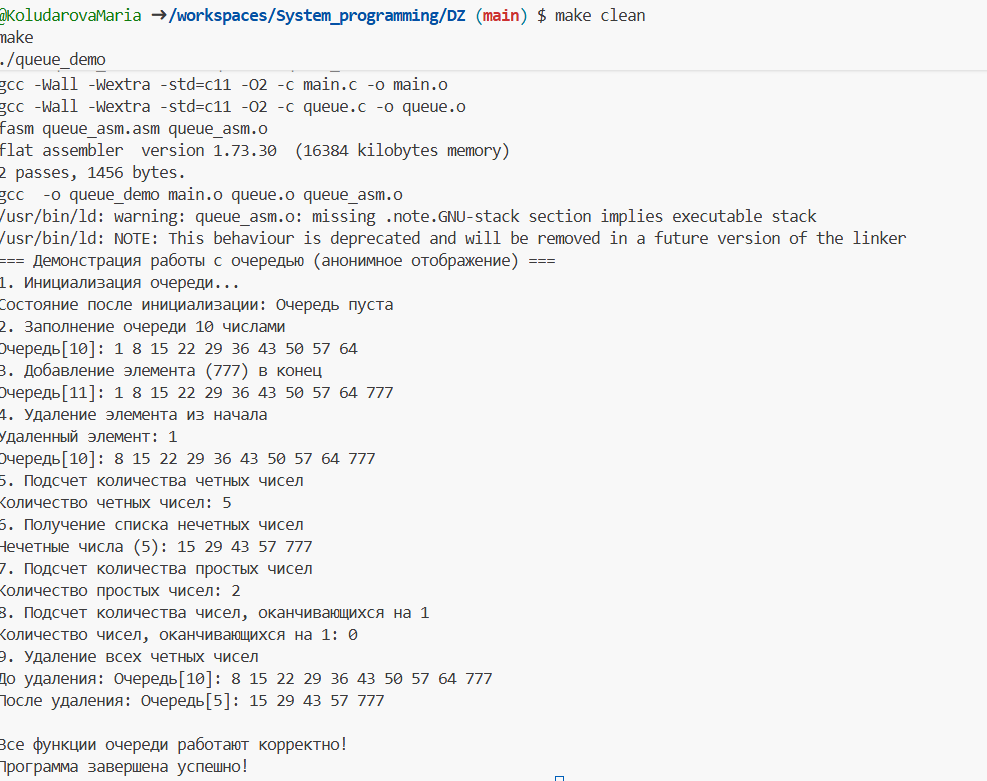